MSc Project

This aim of this project is to find insights into socio-demographic and economic factors that matter to life satisfaction, the main research question is, What matters most to peoples life satisfaction. The data used in this project is from the UK Data Archive and its a Annual Population Survey Three-Year Pooled Dataset, January 2021 - December 2023.

In [1]:
import pandas as pd

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',  # nullable integer (handles -8 as NA)
        'CombinedAuthorities': 'string'
    },
    na_values=[-8]
)

# View the first few rows
df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2.0,3,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,-9.0
1,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
2,11,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,12,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,5.0,-9.0,-9.0
4,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341465 entries, 0 to 341464
Columns: 459 entries, AAGE to YVARY99
dtypes: Int64(1), float64(231), int64(212), object(14), string(1)
memory usage: 1.2+ GB


There are 341465 entries and 459 attributes.

In [7]:
# Count missing values in each column
missing_counts = df.isna().sum()

# Display missing values only for columns that have any
missing_counts[missing_counts > 0]

ACTWKDY1     552
ADDJOB        22
ANXIOUS     1082
APPR12         3
APPRCURR       4
            ... 
YPAYM          9
YPTJOB       253
YSTART         8
YTETJB         1
YVARY99       12
Length: 220, dtype: int64

First to start off the MSc project we need a measurement for the personal wellbeing level of UK citizens.

Pos.348(SATIS)-Overall, how satisfied are you with your life nowadays?

Pos.441(WORTH)-Overall, to what extent do you feel the things you do in your life are worthwhile?

Pos.122(HAPPY)-Overall, how happy did you feel yesterday?

Pos.15(ANXIOUS)-Overall, how anxious did you feel yesterday?

These 4 questions are about personal wellbeings and citizens are asked to respond on a scale of 0 to 10, making it easy for us to analyze. Estimates is then produced by taking the mean ratings of the 4 wellbeing questions. For life satisfaction, life worthwhile and happiness will be combined into one score and anxiety will be done seperatly because they dont mean the same for scores.

In [9]:
# Create Wellbeing column
df['Wellbeing'] = df[['SATIS', 'WORTH', 'HAPPY']].mean(axis=1, skipna=True)

# Check the result
df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head()

,SATIS,WORTH,HAPPY,Wellbeing
0,8.0,8.0,7.0,7.666667
1,10.0,8.0,10.0,9.333333
2,10.0,9.0,10.0,9.666667
3,-9.0,-9.0,-9.0,-9.000000
4,8.0,5.0,8.0,7.000000


The following code creates labels for hresholds for life satisfaction, worthwhile, happiness and anxiety scores.

In [11]:
# Replace missing codes in Wellbeing column
df['Wellbeing'] = df['Wellbeing'].replace([-9, -8], pd.NA)
def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 4:
        return 'Low'
    elif score <= 6:
        return 'Medium'
    elif score <= 8:
        return 'High'
    else:
        return 'Very high'

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing)

# Replace missing codes in ANXIOUS column
df['ANXIOUS'] = df['ANXIOUS'].replace([-9, -8], pd.NA)

def classify_anxiety(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 1:
        return 'Very low'
    elif score <= 3:
        return 'Low'
    elif score <= 5:
        return 'Medium'
    else:
        return 'High'

df['Anxiety_category'] = df['ANXIOUS'].apply(classify_anxiety)

df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].head()

,Wellbeing,Wellbeing_category,ANXIOUS,Anxiety_category
0,7.666667,High,7.0,High
1,9.333333,Very high,0.0,Very low
2,9.666667,Very high,0.0,Very low
3,<NA>,<NA>,<NA>,<NA>
4,7.0,High,1.0,Very low


In [12]:
df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].isna().sum()

Wellbeing             169132
Wellbeing_category    169132
ANXIOUS               169369
Anxiety_category      169369
dtype: int64

Wellbeing and anxious is our 2 most important measurements, so if data are missing in both of these attributes predictions cannot be made, to prevent bias the entire row is dropped if both Wellbeing and ANXIOUS are missing.

In [14]:
cleaned = df[~(df['Wellbeing'].isna() & df['ANXIOUS'].isna())]

cleaned[['Wellbeing', 'ANXIOUS']].isna().sum()

Wellbeing     11
ANXIOUS      248
dtype: int64

In [15]:
category_order = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very high': 4
}
cleaned = cleaned.copy()
cleaned['Wellbeing_category_num'] = cleaned['Wellbeing_category'].map(category_order)

In this reasearch of wellbeing interviewees with age under 16 will be excluded since lots of the determinants are targetted to audiences over 16 and doesnt apply on non adults.

In [17]:
# Remove rows where AAGE indicates "Under 16"
cleaned = cleaned[cleaned['AAGE'] != 1.0]
print(cleaned['AAGE'].value_counts().sort_index())

AAGE
2       293
3       525
4      2909
5      6573
6      9586
7     10685
8     11510
9     11813
10    14584
11    17031
12    18517
13    68318
Name: count, dtype: int64


In [18]:
# Define mapping
aage_to_avg = {
    2.0: 17,  # 16-17
    3.0: 19,  # 18-19
    4.0: 22,    # 20-24
    5.0: 27,    # 25-29
    6.0: 32,    # 30-34
    7.0: 37,    # 35-39
    8.0: 42,    # 40-44
    9.0: 47,    # 45-49
    10.0: 52,   # 50-54
    11.0: 57,   # 55-59
    12.0: 62,   # 60-64
    13.0: 82    # 65-99
}

# Apply mapping 
cleaned['AGE'] = cleaned['AAGE'].map(aage_to_avg)

In [19]:
# Map GOR9d to numeric codes
region_map = {
    'E12000001': 1,  # North East
    'E12000002': 2,  # North West
    'E12000003': 3,  # Yorkshire and The Humber
    'E12000004': 4,  # East Midlands
    'E12000005': 5,  # West Midlands
    'E12000006': 6,  # East of England
    'E12000007': 7,  # London
    'E12000008': 8,  # South East
    'E12000009': 9,  # South West
    'L99999999': 10, # Channel Islands (pseudo)
    'M99999999': 11, # Isle of Man (pseudo)
    'N99999999': 12, # Northern Ireland
    'S99999999': 13, # Scotland (pseudo)
    'W99999999': 14  # Wales (pseudo)
}

# Apply the mapping to create a new column
cleaned['GOR9d_num'] = cleaned['GOR9d'].map(region_map)

In [ ]:
import numpy as np

# Step 1: Define HEALPB2001 to HEALPB2010
health_cols = [f'HEALPB20{str(i).zfill(2)}' for i in range(1, 11)]

# Step 2: Ensure correct dtype
for col in health_cols:
    cleaned[col] = cleaned[col].astype('Int64')

# Step 3: Replace -8 with NaN (keep -9)
cleaned[health_cols] = cleaned[health_cols].replace(-8, np.nan)

# Step 4: Define mapping of health code to descriptive name
health_labels = {
    1: "ArmsOrHands",
    2: "LegsOrFeet",
    3: "BackOrNeck",
    4: "SeeingDifficulty",
    5: "HearingDifficulty",
    6: "SpeechImpediment",
    7: "Disfigurements",
    8: "BreathingProblems",
    9: "HeartOrCirculation",
    10: "DigestiveOrgans",
    11: "Diabetes",
    12: "MentalAnxiety",
    13: "Epilepsy",
    14: "LearningDifficulties",
    15: "MentalIllness",
    16: "ProgressiveIllness",
    17: "OtherProblems",
    18: "Autism"
}

# Step 5: Only create columns if they don’t already exist
for code, label in health_labels.items():
    col_name = f'HEALTH_{label}'
    if col_name not in cleaned.columns:
        cleaned[col_name] = cleaned[health_cols].apply(
            lambda row: int(code in row.dropna().values), axis=1
        )

print("HEALTH columns created.")

In [ ]:
cleaned.to_csv("cleaned.csv", index=False)

In [3]:
import pandas as pd
cleaned = pd.read_csv("cleaned.csv",low_memory=False)

## **Data exploration**


In [5]:
# Dictionary
feature_labels = {
    # SEX
    'SEX_1': 'Male',
    'SEX_2': 'Female',

    # ETHUKEUL (Ethnicity)
    'ETHUKEUL_1.0': 'White',
    'ETHUKEUL_2.0': 'Mixed/Multiple ethnic groups',
    'ETHUKEUL_3.0': 'Indian',
    'ETHUKEUL_4.0': 'Pakistani',
    'ETHUKEUL_5.0': 'Bangladeshi',
    'ETHUKEUL_6.0': 'Chinese',
    'ETHUKEUL_7.0': 'Any other Asian background',
    'ETHUKEUL_8.0': 'Black/African/Caribbean/Black British',
    'ETHUKEUL_9.0': 'Other ethnic group',

    # MARDY6 (Marital status)
    'MARDY6_1': 'Married/Cohabiting/Civil Partner',
    'MARDY6_2': 'Non-married',

    # ILODEFR (Economic activity)
    'ILODEFR_1': 'In employment',
    'ILODEFR_2': 'ILO unemployed',
    'ILODEFR_3': 'Inactive',

    # TEN1 (Accommodation details)
    'TEN1_1.0': 'Owned outright',
    'TEN1_2.0': 'Being bought with mortgage or loan',
    'TEN1_3.0': 'Part rent, part mortgage',
    'TEN1_4.0': 'Rented',
    'TEN1_5.0': 'Rent free or squatted',
    'TEN1_6.0': 'Squatting',

    # XDISDDA20 (Unadjusted DDA disabled)
    'XDISDDA20_-9': 'Does not apply',
    'XDISDDA20_1': 'Current disability only',
    'XDISDDA20_2': 'Current and past disabled',
    'XDISDDA20_3': 'Past disability only',
    'XDISDDA20_4': 'Not DDA disabled',

    # LEVQUL22 (RQF Level of highest qualification)
    'LEVQUL22_-9': 'Does not apply',
    'LEVQUL22_1': 'RQF Level 8 (Doctorate)',
    'LEVQUL22_2': 'RQF Level 7 (Master’s)',
    'LEVQUL22_3': 'RQF Level 6 (Bachelor’s)',
    'LEVQUL22_4': 'RQF Level 5 (HND/Foundation Degree)',
    'LEVQUL22_5': 'RQF Level 4 (CertHE)',
    'LEVQUL22_6': 'RQF Level 3 (A-Levels)',
    'LEVQUL22_7': 'RQF Level 2 (GCSE A*-C)',
    'LEVQUL22_8': 'RQF Level 1 (GCSE D-G)',
    'LEVQUL22_9': 'RQF Entry Level',
    'LEVQUL22_10': 'Other Qualifications',
    'LEVQUL22_11': 'No Qualifications',
    'LEVQUL22_12': 'Don’t Know (Qualification)',

    # INDE07M (Industry sector in main job)
    'INDE07M_-9.0': 'Does not apply',
    'INDE07M_1.0': 'Agriculture, forestry and fishing',
    'INDE07M_2.0': 'Energy and water',
    'INDE07M_3.0': 'Manufacturing',
    'INDE07M_4.0': 'Construction',
    'INDE07M_5.0': 'Distribution, hotels and restaurants',
    'INDE07M_6.0': 'Transport and communication',
    'INDE07M_7.0': 'Banking and finance',
    'INDE07M_8.0': 'Public admin, education and health',
    'INDE07M_9.0': 'Other services',

    # RELIG11 (Religion)
    'RELIG11_1.0': 'No Religion',
    'RELIG11_2.0': 'Christian',
    'RELIG11_3.0': 'Buddhist',
    'RELIG11_4.0': 'Hindu',
    'RELIG11_5.0': 'Jewish',
    'RELIG11_6.0': 'Muslim',
    'RELIG11_7.0': 'Sikh',
    'RELIG11_8.0': 'Other Religion',

    # GOR9d (Region)
    '1': 'North East',
    '2': 'North West',
    '3': 'Yorkshire and The Humber',
    '4': 'East Midlands',
    '5': 'West Midlands',
    '6': 'East of England',
    '7': 'London',
    '8': 'South East',
    '9': 'South West',
    '10': '(pseudo) Channel Islands',
    '11': '(pseudo) Isle of Man',
    '12': 'Northern Ireland',
    '13': '(pseudo) Scotland',
    '14': '(pseudo) Wales',

    # HEALTH binary indicators
    'HEALTH_Diabetes': 'Diabetes',
    'HEALTH_MentalAnxiety': 'Mental Anxiety',
    'HEALTH_ArmsOrHands': 'Arms/Hands Disability',
    'HEALTH_LegsOrFeet': 'Legs/Feet Disability',
    'HEALTH_BackOrNeck': 'Back/Neck Disability',
    'HEALTH_MentalIllness': 'Mentai Illness',
    'HEALTH_Autism': 'Autism',
    'HEALTH_ProgressiveIllness': 'ProgressiveIllness',
    'HEALTH_HeartOrCirculation': 'HeartOrCirculation',
    'NATIDB11': 'British Identity',
}

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Step 1: Define feature mappings and column groups ---
columns = {
    'AGE': 'AGE',
    'SEX': 'SEX',
    'ETHNICITY': 'ETHUKEUL',
    'MIGRATION': 'NATIDB11',
    'REL_STATUS': 'MARDY6',
    'ECON_ACTIVITY': 'ILODEFR',
    'TENURE': 'TEN1',
    'DISABILITY': 'XDISDDA20',
    'QUALIFICATION': 'LEVQUL22',
    'Job_Sector': 'INDE07M',
    'RELIGION': 'RELIG11',
    'REGION': 'GOR9d_num',
    'DIABETES': 'HEALTH_Diabetes',
    'MentalAnxiety': 'HEALTH_MentalAnxiety',
    'ArmsDisability': 'HEALTH_ArmsOrHands',
    'LegsDisability': 'HEALTH_LegsOrFeet',
    'BackDisability': 'HEALTH_BackOrNeck',
    'MentalIllness': 'HEALTH_MentalIllness',
    'Autism': 'HEALTH_Autism',
    'ProgressiveIllness': 'HEALTH_ProgressiveIllness',
    'HeartOrCirculation': 'HEALTH_HeartOrCirculation'
}

nominal_cols = [
    'LEVQUL22', 'ILODEFR', 'MARDY6', 'SEX', 'ETHUKEUL',
    'TEN1', 'XDISDDA20', 'INDE07M', 'RELIG11', 'GOR9d_num'
]

binary_cols = [
    'NATIDB11', 'HEALTH_Diabetes', 'HEALTH_MentalAnxiety',
    'HEALTH_ArmsOrHands', 'HEALTH_LegsOrFeet', 'HEALTH_BackOrNeck',
    'HEALTH_MentalIllness', 'HEALTH_Autism',
    'HEALTH_ProgressiveIllness', 'HEALTH_HeartOrCirculation'
]

continuous_cols = ['AGE']

# --- Step 2: Filter and clean dataset ---
relevant_cols = list(columns.values()) + ['Wellbeing_category_num']
model_df = cleaned[relevant_cols].dropna()

# --- Step 3: Define features and target ---
X = model_df[list(columns.values())].copy()
y = model_df['Wellbeing_category_num']

# --- Step 4: Set correct data types ---
X[binary_cols] = X[binary_cols].astype(int)

for col in nominal_cols:
    X[col] = X[col].astype('category')

X[continuous_cols] = X[continuous_cols].apply(pd.to_numeric, errors='coerce')

# --- Step 5: One-hot encode nominal features ---
X_encoded = pd.get_dummies(X[nominal_cols], drop_first=False)
X_final = pd.concat([X[continuous_cols], X[binary_cols], X_encoded], axis=1)

# --- Step 6: Train/Validation/Test split ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# --- Step 7: Output shape summary ---
print(f"Train:       {X_train.shape}")
print(f"Validation:  {X_val.shape}")
print(f"Test:        {X_test.shape}")

Train:       (113869, 78)
Validation:  (24401, 78)
Test:        (24401, 78)



--- Class Distribution ---
Full dataset:
 Wellbeing_category_num
1.0     5774
2.0    18735
3.0    74053
4.0    64109
Name: count, dtype: int64

Training set BEFORE SMOTE:
 Wellbeing_category_num
1.0     4042
2.0    13114
3.0    51837
4.0    44876
Name: count, dtype: int64


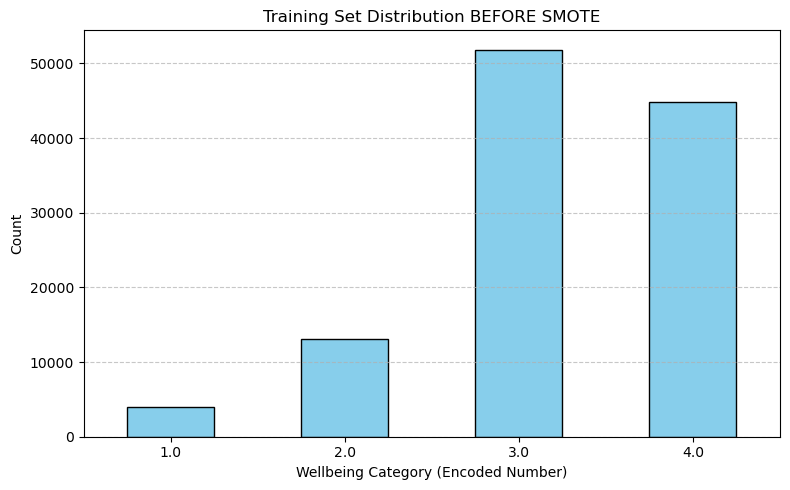


Training set AFTER SMOTE:
 Wellbeing_category_num
1.0    51837
2.0    51837
3.0    51837
4.0    51837
Name: count, dtype: int64


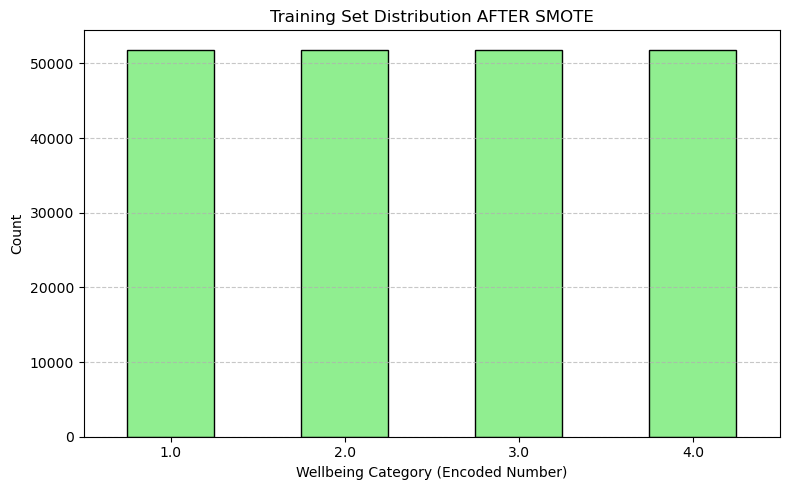

In [32]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# --- Step 1: Scale continuous features (AGE) ---
scaler = StandardScaler()

X_train_cont = scaler.fit_transform(X_train[continuous_cols])
X_val_cont   = scaler.transform(X_val[continuous_cols])
X_test_cont  = scaler.transform(X_test[continuous_cols])

# --- Step 2: Combine scaled + binary + one-hot encoded nominal features ---
def combine_features(X_cont, X_bin, X_nom):
    return np.hstack([X_cont, X_bin.values, X_nom.values])

X_train_scaled = combine_features(X_train_cont, X_train[binary_cols], X_train[X_nominal.columns])
X_val_scaled   = combine_features(X_val_cont, X_val[binary_cols], X_val[X_nominal.columns])
X_test_scaled  = combine_features(X_test_cont, X_test[binary_cols], X_test[X_nominal.columns])

# --- Step 3: Apply SMOTE to balance training set only ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Step 4: Print and plot class distribution before and after SMOTE ---
def plot_distribution(series, title, color):
    plt.figure(figsize=(8, 5))
    series.value_counts().sort_index().plot(
        kind='bar', color=color, edgecolor='black'
    )
    plt.xlabel('Wellbeing Category (Encoded Number)')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n--- Class Distribution ---")
print("Full dataset:\n", y.value_counts().sort_index())
print("\nTraining set BEFORE SMOTE:\n", y_train.value_counts().sort_index())

plot_distribution(y_train, "Training Set Distribution BEFORE SMOTE", "skyblue")

print("\nTraining set AFTER SMOTE:\n", pd.Series(y_train_resampled).value_counts().sort_index())
plot_distribution(pd.Series(y_train_resampled), "Training Set Distribution AFTER SMOTE", "lightgreen")

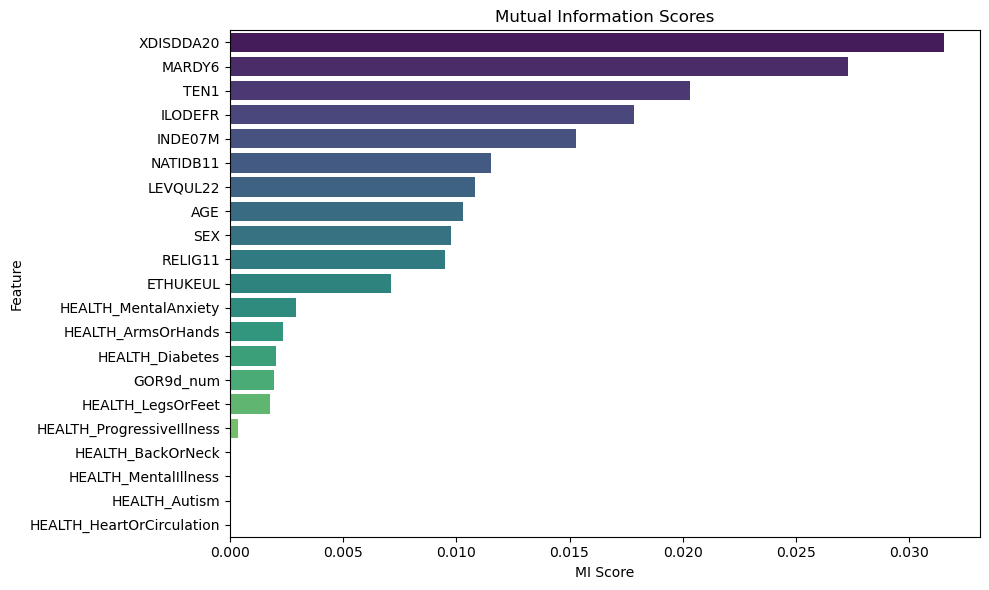

In [50]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# Step 1: Compute Mutual Information scores
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# Step 2: Create a DataFrame for easy plotting and sorting
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=mi_df, x='MI Score', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Mutual Information Scores')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## **Model building**


--- Random Forest ---
TRAINING SET
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.93     51837
         2.0       0.87      0.84      0.86     51837
         3.0       0.87      0.74      0.80     51837
         4.0       0.73      0.86      0.79     51837

    accuracy                           0.84    207348
   macro avg       0.85      0.84      0.84    207348
weighted avg       0.85      0.84      0.84    207348



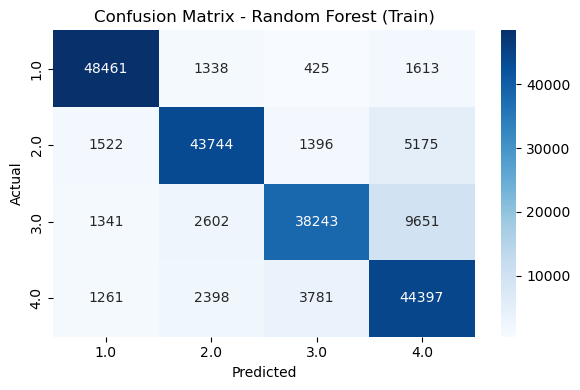

TEST SET
              precision    recall  f1-score   support

         1.0       0.10      0.12      0.11       866
         2.0       0.18      0.17      0.18      2811
         3.0       0.49      0.47      0.48     11108
         4.0       0.46      0.50      0.48      9616

    accuracy                           0.43     24401
   macro avg       0.31      0.31      0.31     24401
weighted avg       0.43      0.43      0.43     24401



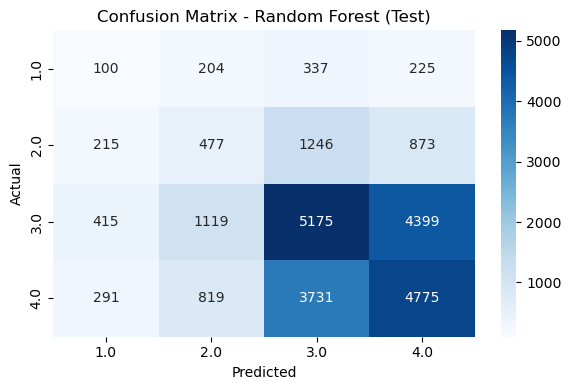

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Function to plot a labeled confusion matrix ---
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# --- Define classifiers ---
models = {
    # "Logistic Regression (L2)": LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42),
    # "Lasso Logistic Regression (L1)": LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l1', solver='liblinear', random_state=42),
    # "Ridge Classifier": RidgeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    # "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# --- Train and evaluate each model ---
def evaluate_model(name, model):
    print(f"\n--- {name} ---")

    # Train
    model.fit(X_train_resampled, y_train_resampled)

    # Predict & evaluate on training set
    y_pred_train = model.predict(X_train_resampled)
    print("TRAINING SET")
    print(classification_report(y_train_resampled, y_pred_train))
    cm_train = confusion_matrix(y_train_resampled, y_pred_train)
    plot_confusion_matrix(cm_train, sorted(set(y_train_resampled)), f"{name} (Train)")

    # Predict & evaluate on test set
    y_pred_test = model.predict(X_test_scaled)
    print("TEST SET")
    print(classification_report(y_test, y_pred_test))
    cm_test = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(cm_test, sorted(set(y_test)), f"{name} (Test)")

# --- Run evaluation ---
for name, model in models.items():
    evaluate_model(name, model)